# This Notebook explores the SCAR GeoMAP dataset released in 2019
## Cox S.C., Smith Lyttle B. and the GeoMAP team (2019). Lower Hutt, New Zealand. GNS Science. Release v.201907.
### [Data Available Here](https://data.gns.cri.nz/ata_geomap/index.html?content=/mapservice/Content/antarctica/www/index.html)

Initially, I'll look at the data in terms of polygon counts. This section will be focused on examining the data schema and frequency of values occurring within specific fields. This investigation will focus on finding inconsistencies in the data attribution, but also could stimulate some discussion regarding relationships between columns.

Next, I'll look at the data in terms of polygon area and data attribution. How much surface water has been mapped? How much till has been mapped? How much outcropping rock is of Jurassic age?

## Configure packages, paths, and load data

In [120]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import pprint as pp
from tabulate import tabulate

In [3]:
geol_path = f"{os.getcwd()}/data/ATA_SCAR_GeoMAP_geology.gdb"
print(geol_path)

/home/sam/geomap/data/ATA_SCAR_GeoMAP_geology.gdb


In [4]:
data = gpd.read_file(geol_path)

### What can we learn just from looking at the number of unique values for each attribute

In [82]:
nunique_cols = pd.DataFrame(data.nunique())
display(nunique_cols[:14].transpose())
display(nunique_cols[14:28].transpose())
display(nunique_cols[28:].transpose())

,SOURCECODE,MAPSYMBOL,PLOTSYMBOL,NAME,DESCR,POLYGTYPE,MBREQUIV,FMNEQUIV,SBGRPEQUIV,GRPEQUIV,SPGRPEQUIV,TERREQUIV,STRATRANK,TYPENAME
0,801,173,183,666,757,3,19,246,1,59,14,11,12,6


,TYPE_URI,GEOLHIST,REPAGE_URI,YNGAGE_URI,OLDAGE_URI,ABSMIN_MA,ABSMAX_MA,AGECODE,LITHCODE,LITHOLOGY,REPLITH_URI,OBSMETHOD,CONFIDENCE,POSACC_M
0,5,113,41,51,52,121,130,46,25,410,80,5,162,1


,SOURCE,METADATA,RESSCALE,CAPTSCALE,CAPTDATE,MODDATE,FEATUREID,SPEC_URI,SYMBOL,DATASET,REGION,Shape_Length,Shape_Area,geometry
0,158,1,3,1,14,15,95161,1,0,9,2,95072,95057,95128


### Discussion of unique column values

- 95,128 total polys
- 801 original source units have been compressed into 183 units based on the Chronostratigraphic Legend
- My understanding of MAPSYMBOL AND PLOTSYMBOL was that they were pretty much equivalent. Is there a good reason for the fact that they have a different number of unique values?
- Interestingly, there are more SOURCECODE values than NAMEs. It could be important to look into records that have the same NAME, but distinct SOURCECODEs.
- I would also imagine that each named unit should have a single description. Because the DESC field is a longer string, I suspect that there are formatting inconsistencies.
- POLYGTYPE will be a very good column to group by when doing descriptive statistics.
- SUBGRPEQUIV has only one value, is it worth including in the schema?
- There are 12 STRATRANKS, should there be a column for each of them, should the values be normalized to fit within existing EQUIV columns?
- 6 TYPENAME values but only 5 TYPE_URIs.
- LITHCODE and REPLITH_URI may need the same number of values, although those columns may not need to be deterministically related
- LITHOLOGY may need some formatting to reduce the number of unique values.
- CONFIDENCE has 162 unique values. It may be valuable to normalize the values in this field into broader categories, resulting in fewer values
- 152 Sources, It would be interesting to look at citation numbers of each source and possibly rank sources for each DATASET
- SYMBOL seems to be an unused column
- How formal are the Dataset areas? Can we draw well-defined footprints on a continent scale map for them?
- why do some geometries not have Shape_Lengths and areas. Do these need to be recalculated to be included in the next release?


### Starting off with SOURCECODE
#### What does a bar graph tells us about the top 50 most frequently occurring values?

<BarContainer object of 50 artists>

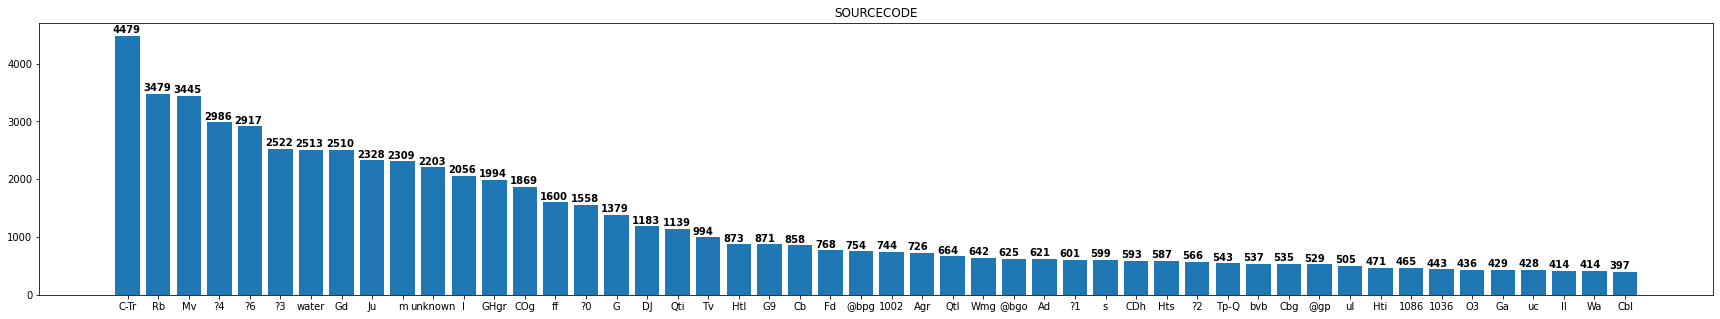

In [215]:
counts = data["SOURCECODE"].value_counts(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(30,5))
values_to_plot = 50
ax.set_title("SOURCECODE")
for i, v in enumerate(counts[:values_to_plot]):
    ax.text(i - .5, v + 50, str(v), color='black', fontweight='bold')
ax.bar(counts.index[:values_to_plot], counts[:values_to_plot])

<BarContainer object of 50 artists>

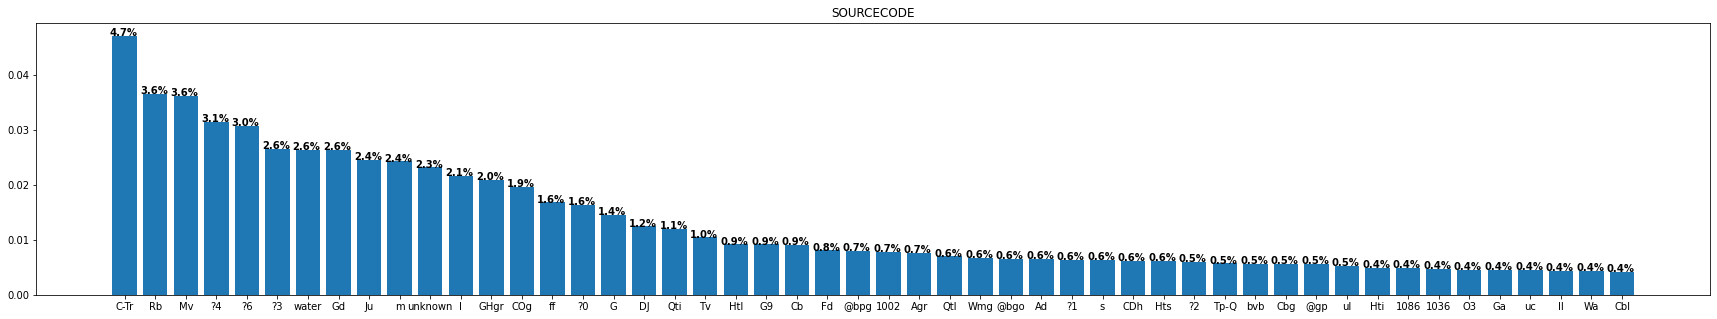

In [213]:
norm_counts = data["SOURCECODE"].value_counts(ascending=False, normalize=True)
fig, ax = plt.subplots(1, 1, figsize=(30,5))
values_to_plot = 50
ax.set_title("SOURCECODE")
for i, v in enumerate(norm_counts[:values_to_plot]):
    ax.text(i - .5, v, f"{str(v * 100)[:3]}%", color='black', fontweight='bold')
ax.bar(norm_counts.index[:values_to_plot], norm_counts[:values_to_plot])

In [235]:
print("number of 'unkown' polys:", counts["unknown"])
display([i for i in counts.index if "unk" in i])
question_marks = [i for i in counts.index if "?" in i]
display(pd.DataFrame(question_marks).transpose())
print("number of polygons with a question mark:", counts[question_marks].sum())
print("number of 'unk's:", counts["unk"])
med_length_vals = [i for i in counts.index if len(i) > 6]
print("labels with more than 6 chars:", len(med_length_vals))
print("number of polys represented by these SOURCECODES:", counts[med_length_vals].sum())
print()
print("displaying source codes longer than 10 chars:")
long_values = [i for i in counts.index if len(i) > 10]
display(pd.DataFrame(long_values).transpose())
print("number of polys represented by these SOURCECODES:", counts[long_values].sum())

number of 'unkown' polys: 2203


['unknown', 'unk']

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,?4,?6,?3,?0,?1,?2,?5,g?,ff?,Mv?,...,PC-B?,gr?,gro?,I?,uc?,fc?,btb?,uir3?,ss?,uk?


number of polygons with a question mark: 11941
number of 'unk's: 111
labels with more than 6 chars: 91
number of polys represented by these SOURCECODES: 4021

displaying source codes longer than 10 chars:


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,MP2-3//NP11bv1,MP3-NP1//NP12pr2,MP3-NP1//NP12pr1,Pb_LMB12.3c,MP1-2//NP1fl,MP2-3//NP11bv2,MP3-NP1//Egr2,MP2-3//NP11bv,Pb_LMB14.2b,MP3-NP1//Egr1,...,Pb_LMB14.2c,Pb_LMB14.2a,Pb_LMB16A.1a,Pb_LMB16D.1_ins,MP3-NP1//NP12sc2,Pb_LMB16D.1d,Pb_LMB16D.1b,MP3-NP1//NP12sc1,Pb_LMB16D.1c,Pb_LMB14.2e


number of polys represented by these SOURCECODES: 642


There are a large number of polys with SOURCECODE: "unknown". Just to make sure there aren't any formatting issues, I've checked for values that have "unk" in them. There's one other source code appearing that is literally "unk". Would be useful to look at the sources of these to see if the code is shorthand for unknown and should be corrected, or is actually a mapped unit.

Following up on unknowns, the question mark was used to indicate uncertainty in the classification. There are 38 SOURCECODES with question marks and these represent nearly 12,000 polygons

Most labels seem to be only a few characters long. With a little filtering we find that there are 91 source codes that have more than 6 characters. There are 26 codes longer than 10 characters. Inspecting these, the notation they follow  appear (to me) to be sample ids from a study (this will have to be cross checked by looking at the sources). If this is the case, these polys would probably be better labeled with a more generic SOURCECODE.

#### What can we learn from looking at the least-represented SOURCECODES?

How many codes are only applied to a single polygon? 

In [239]:
single_codes = pd.DataFrame(counts[counts <= 1])
print("single codes: ", single_codes.shape[0])
display(single_codes)



single codes:  54


,SOURCECODE
NPg3,1
Mev_KF912b,1
Hv_Cl301_3,1
1094,1
ggg,1
Czv,1
gmu,1
MP3-NP1//NP12sc1,1
ggk,1
Jga,1


#### Only 54 codes with a single polygon. That's pretty good.

#### Let's check for potential capitalization errors

In [240]:
lower_codes = [i.lower() for i in counts.index]

In [245]:
print(len(lower_codes))
lower_codes_distinct = set(lower_codes)
print(len(lower_codes_distinct))
cap_error_candidates = pd.DataFrame(lower_codes).value_counts()
print(cap_error_candidates[cap_error_candidates > 1])

801
793
qm     2
g      2
bv     2
mv?    2
mv     2
pcs    2
ocg    2
pp     2
dtype: int64


8 values that are only differentiated by capitalization is great. When they do occur, there is only one variation.

### Let's look at the 10 most frequently occurring values for several of the columns
Later, it will be more interesting to look at this by area rather than number of polygons

In [159]:
value_count_cols = ["SOURCECODE", "PLOTSYMBOL", "POLYGTYPE", "MBREQUIV", "FMNEQUIV", "GRPEQUIV", "TERREQUIV", "STRATRANK", "TYPENAME", "GEOLHIST", "REPAGE_URI", "AGECODE", "LITHCODE", "REPLITH_URI", "OBSMETHOD", "CONFIDENCE", "SOURCE", "DATASET", "REGION",]
print(len(value_count_cols))
value_counts = [data[i].value_counts(ascending=False) for i in value_count_cols]

19


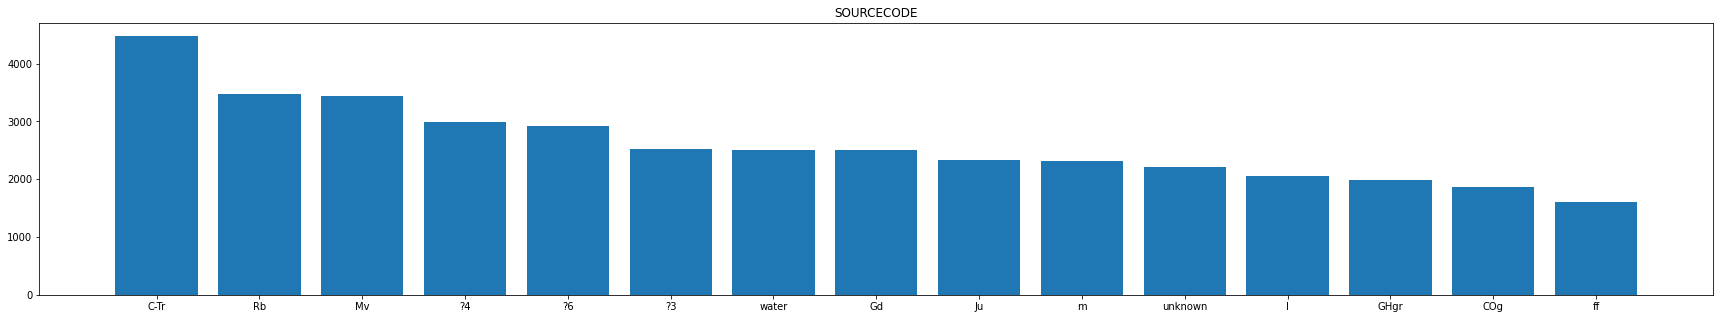

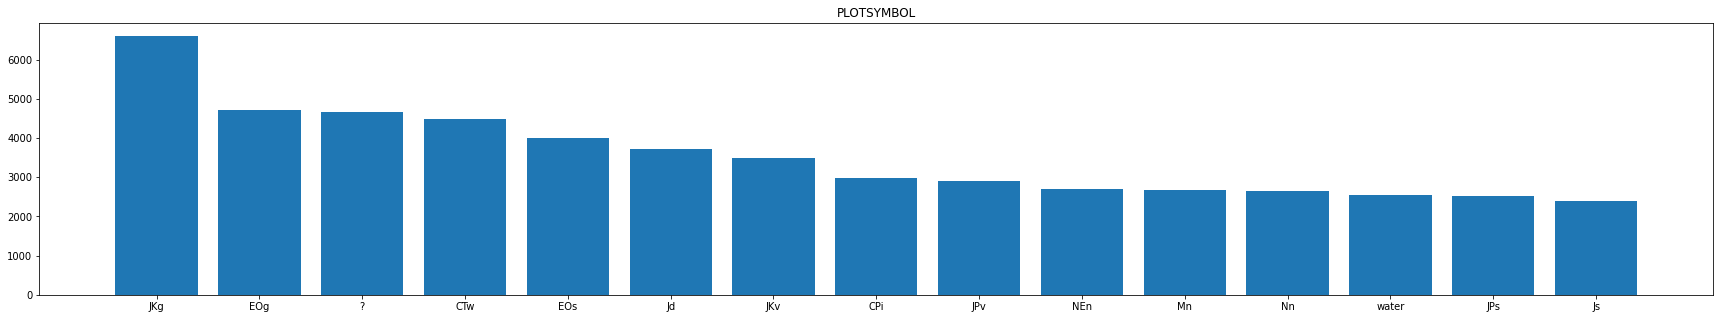

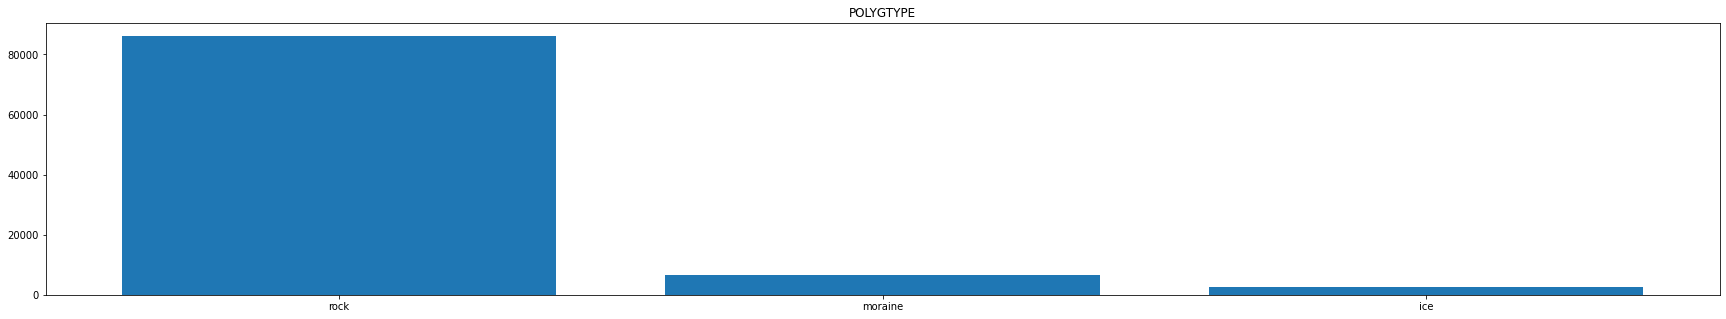

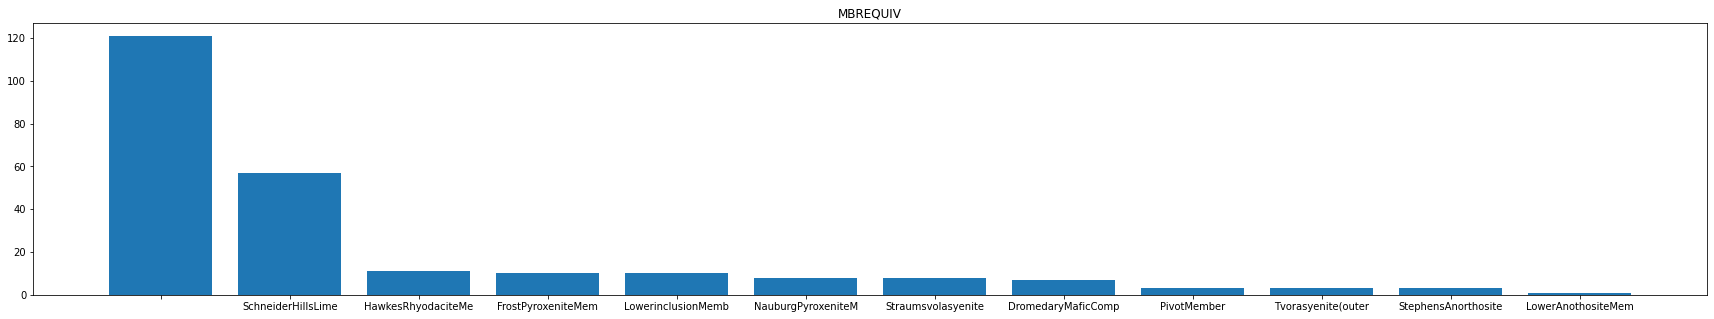

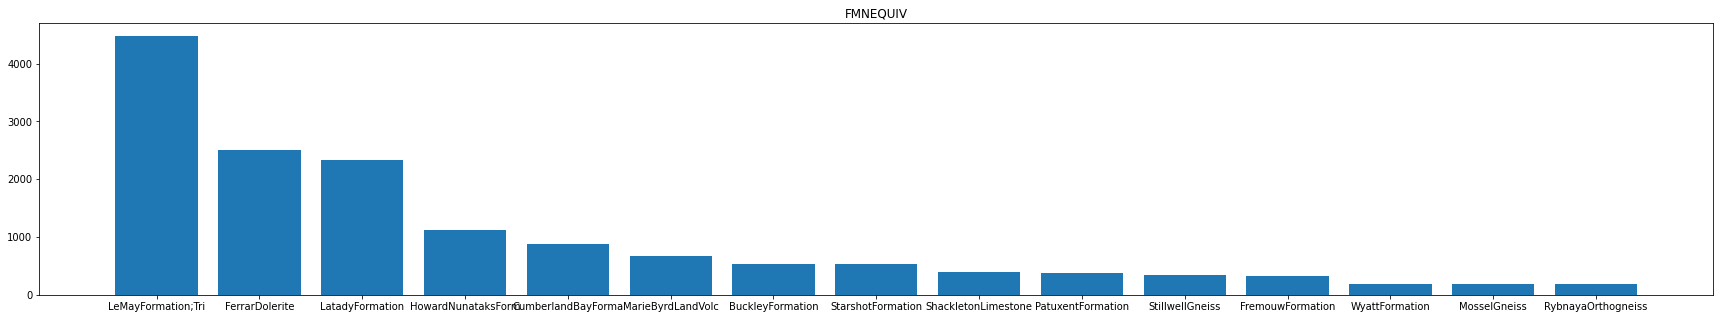

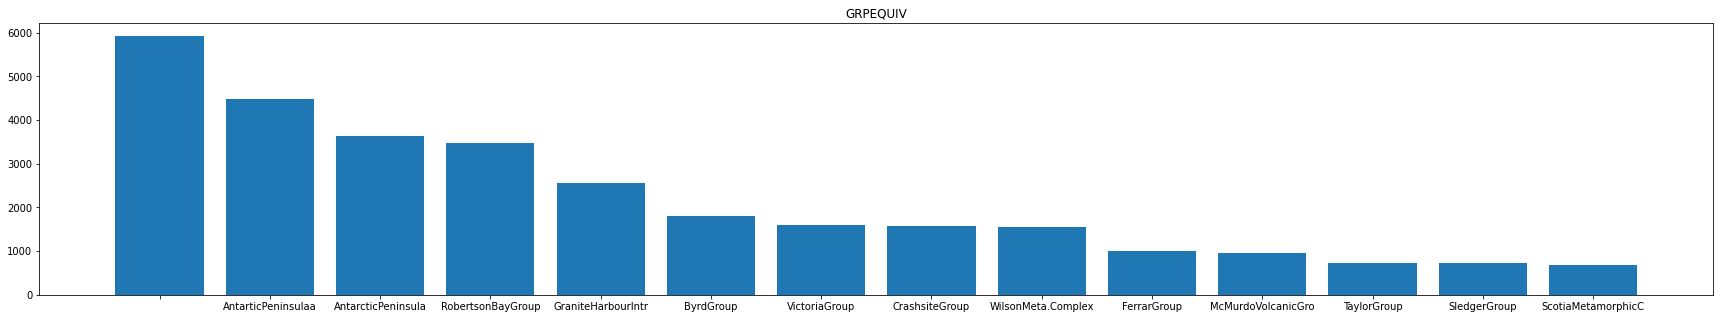

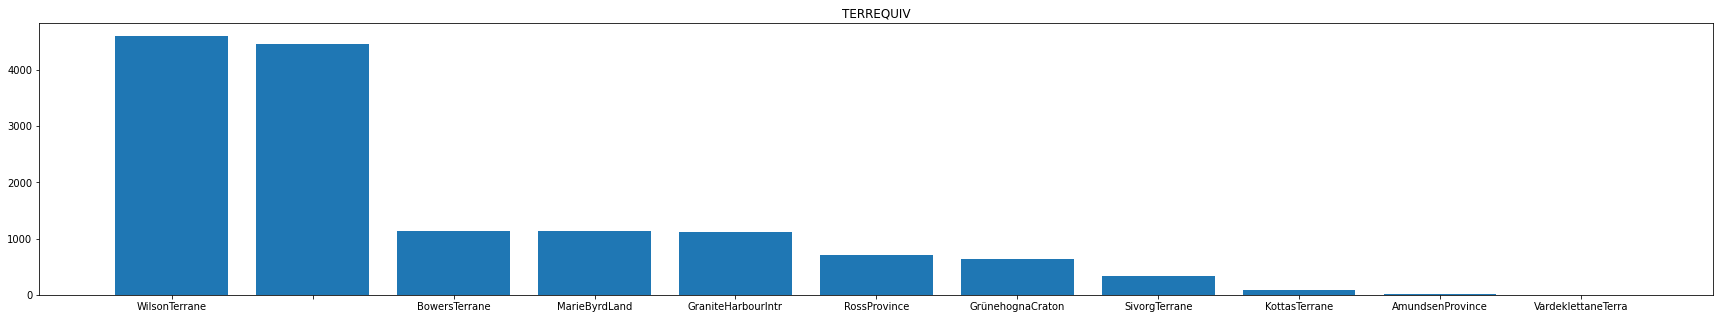

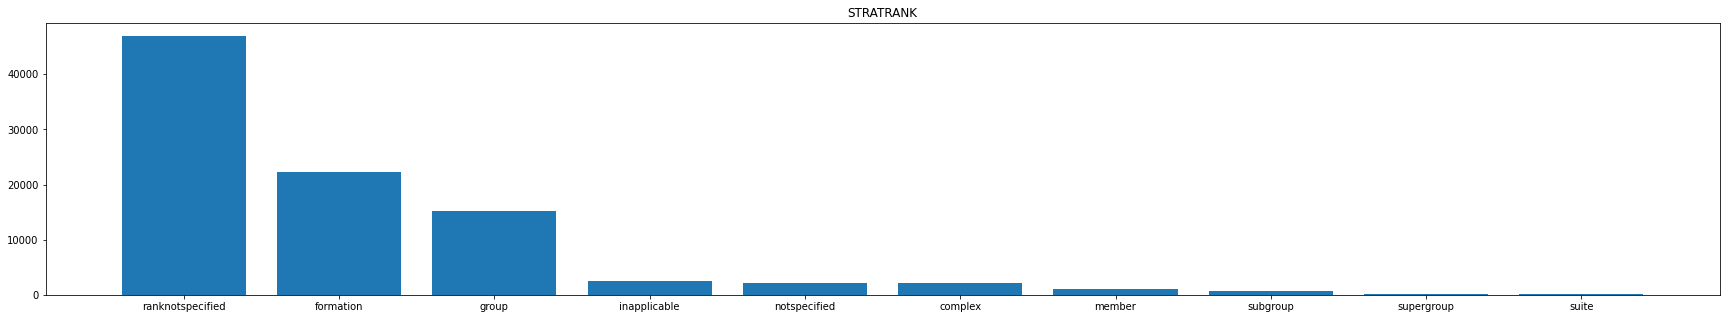

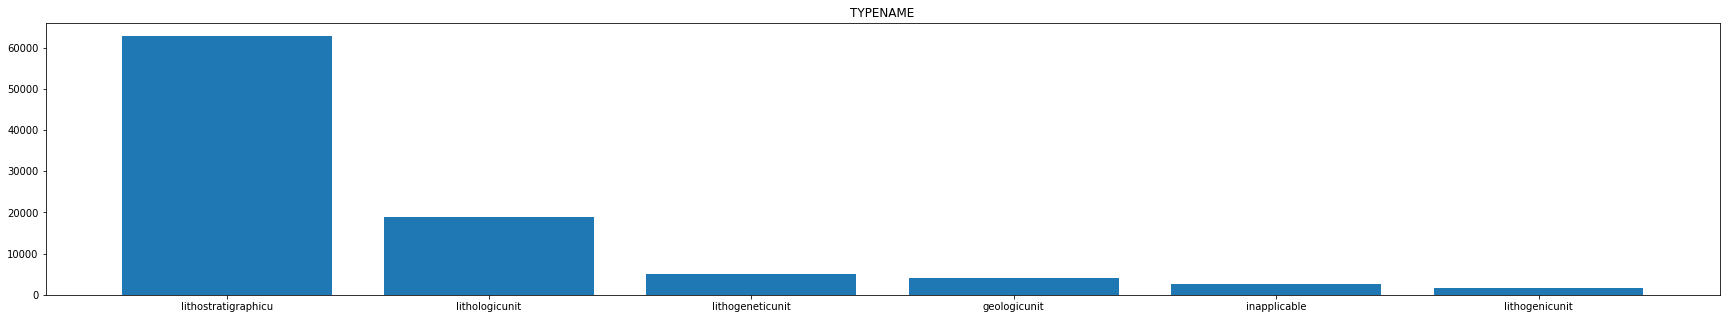

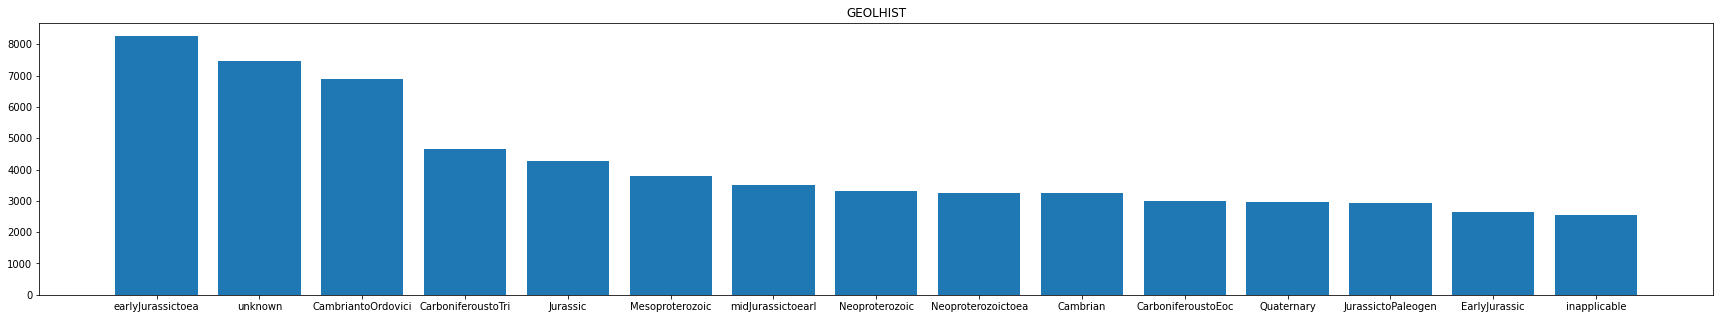

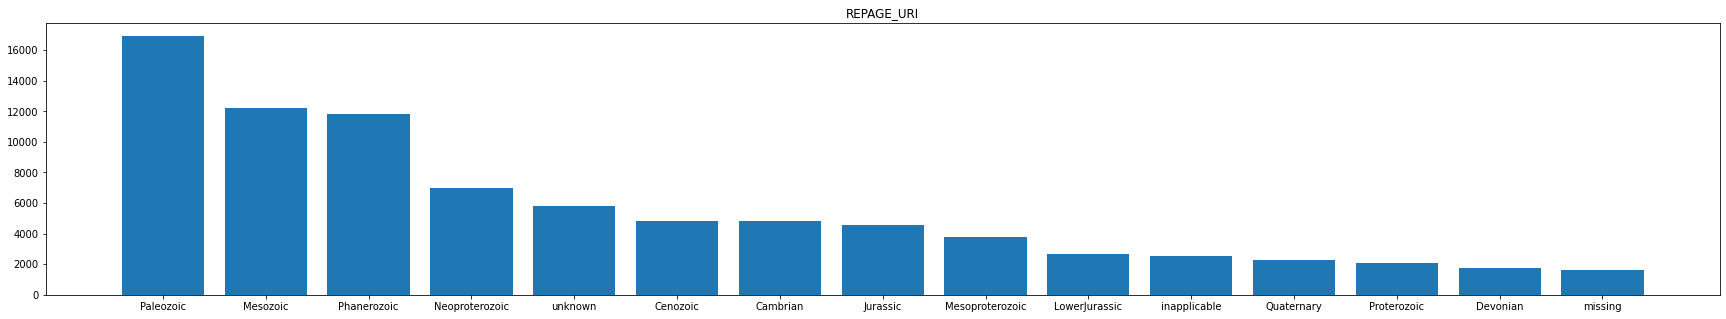

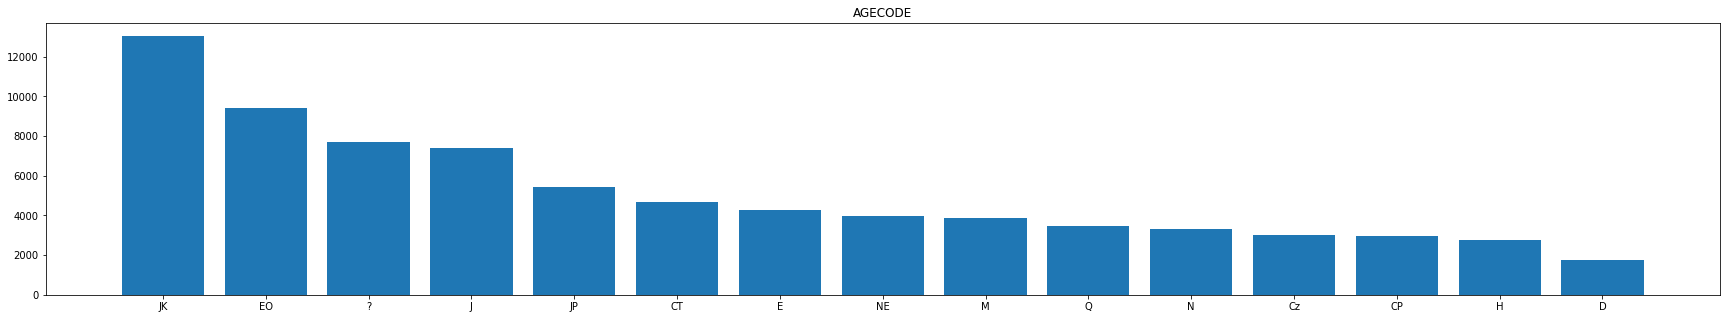

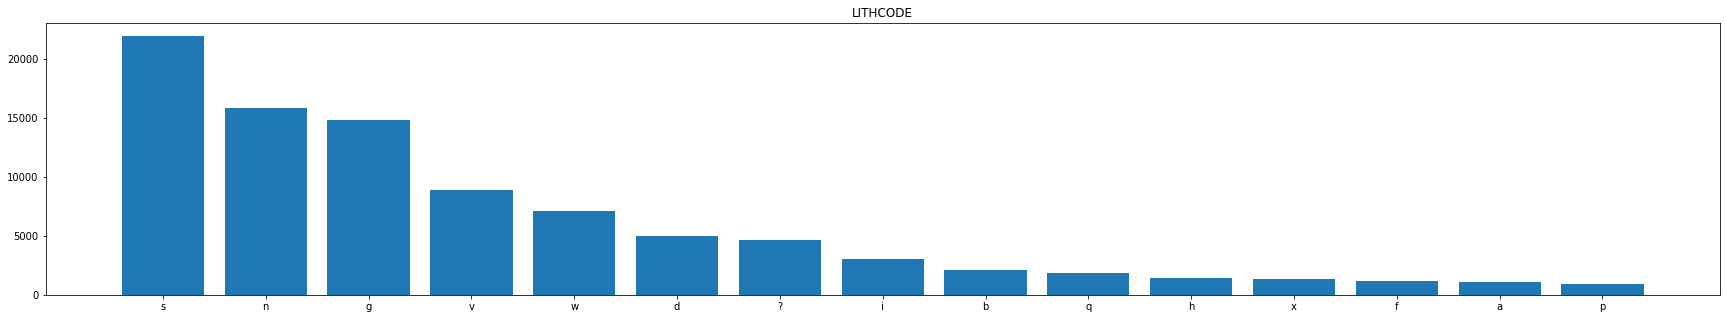

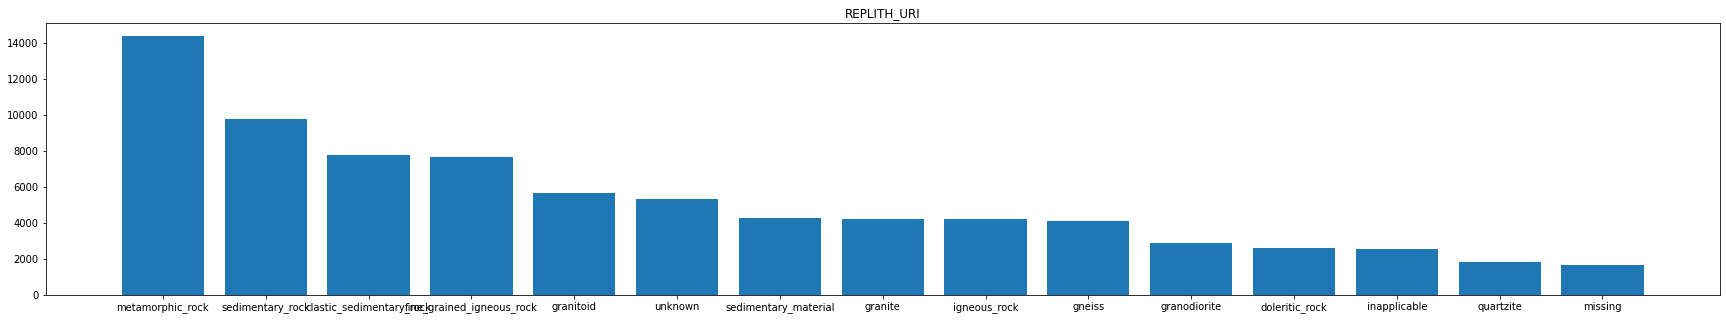

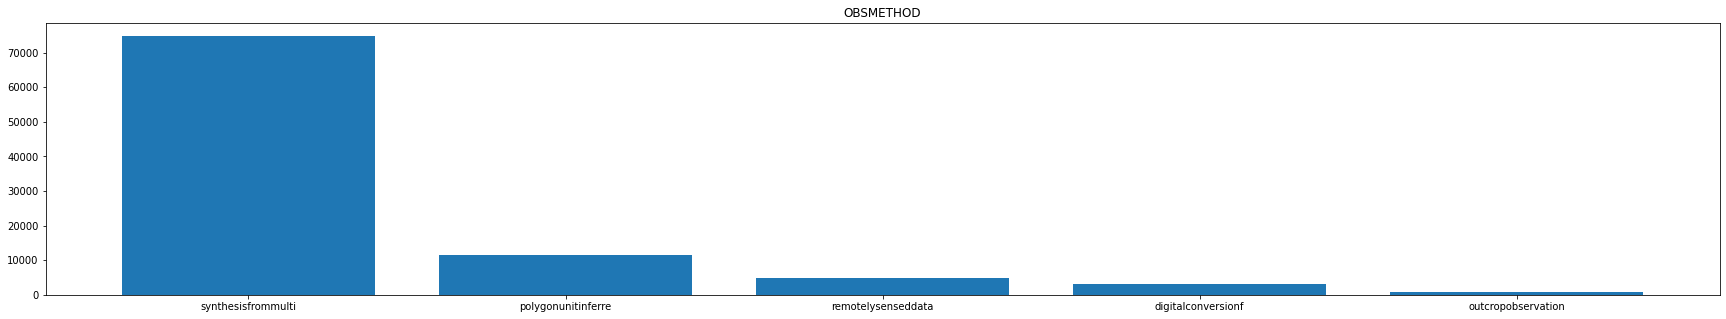

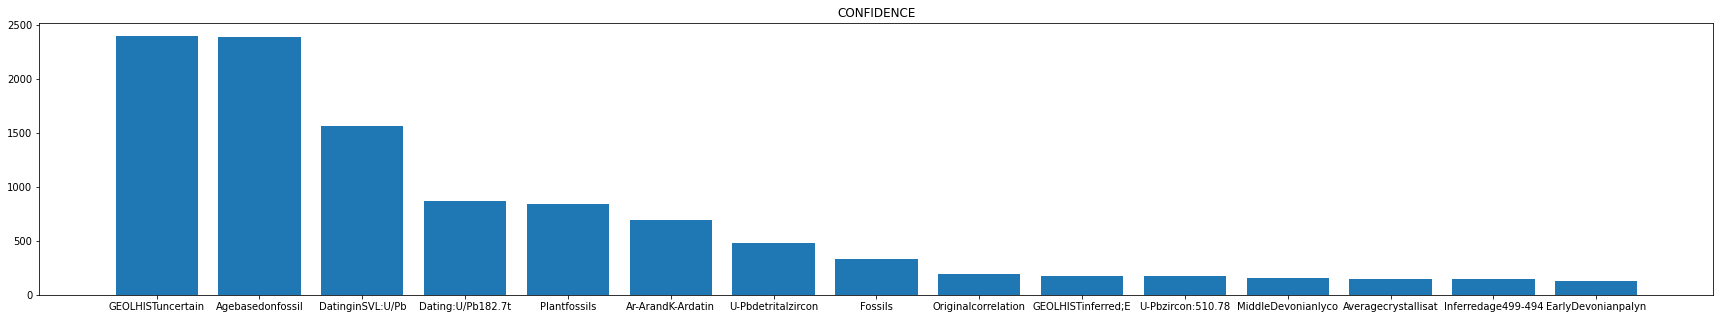

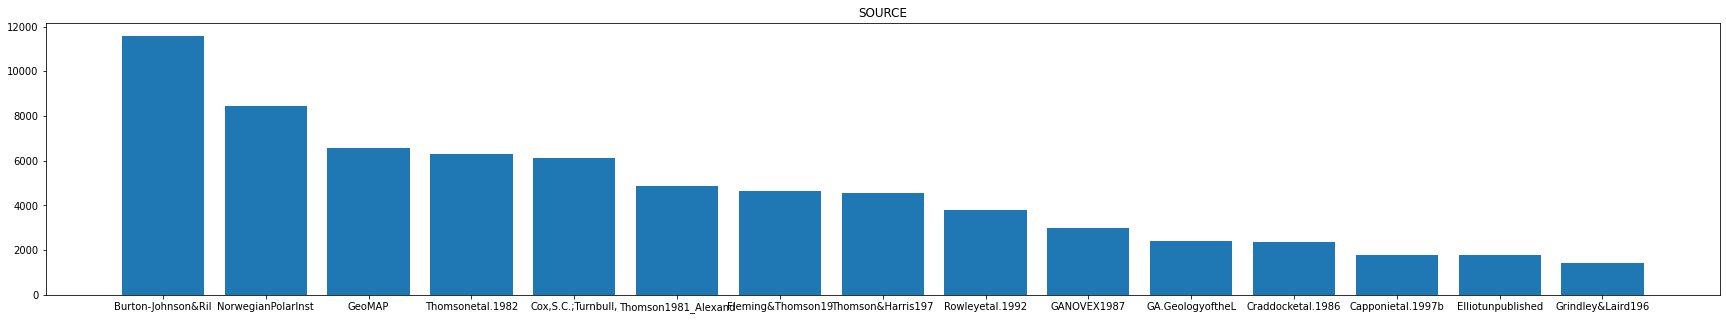

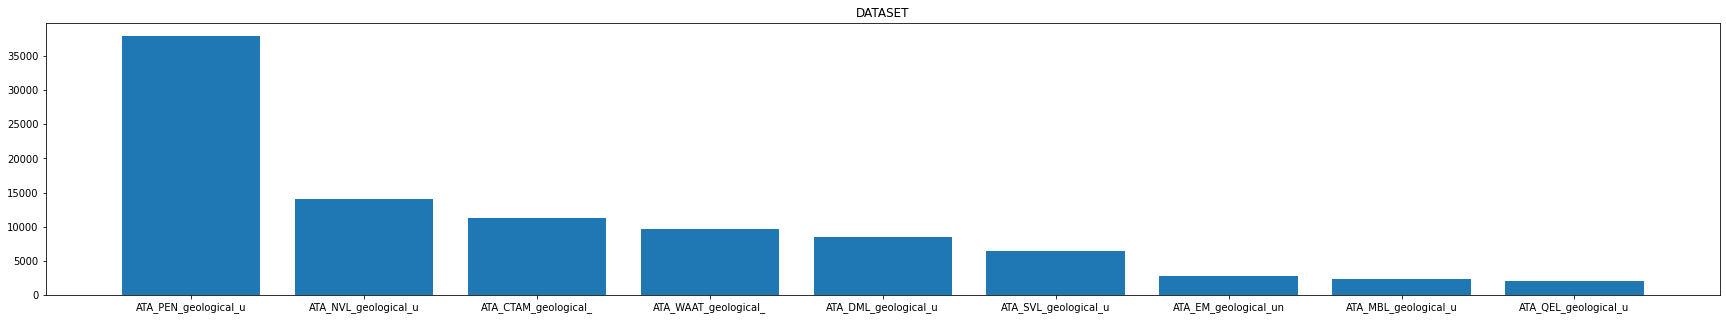

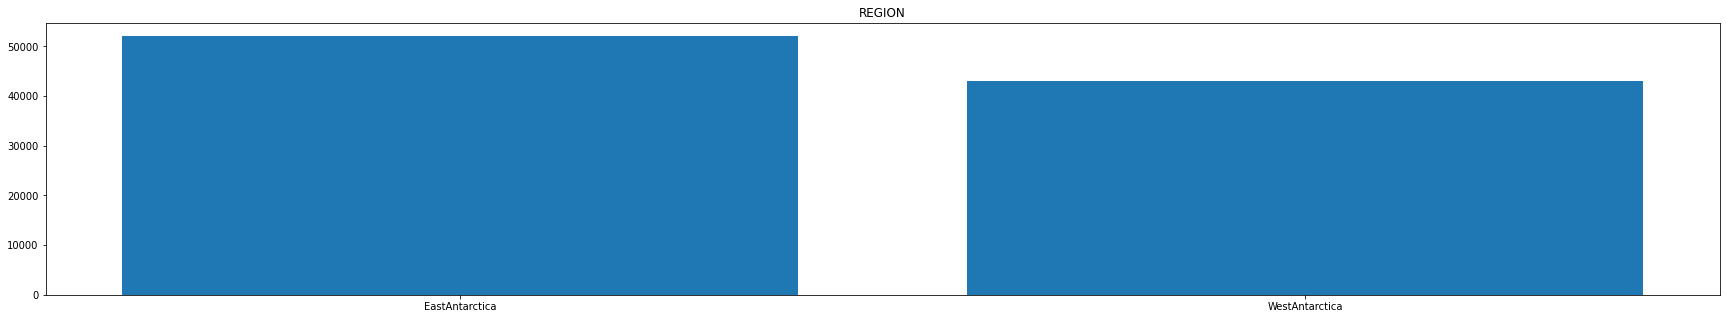

In [160]:
max_bars = 15
label_chars = 20
for i in range(len(value_counts)):
    fig, ax = plt.subplots(1,1, figsize=(30, 5))
        
    ax.set_title(value_count_cols[i])
    counts = len(value_counts[i])
    if counts >= max_bars:
        counts = max_bars 
    try:
        if value_count_cols[i][-4:] == "_URI":
            labels = [j[j.rindex("/") + 1:].replace(" ", "") for j in value_counts[i].index[:counts]]
        else:
            labels = [j[:label_chars].replace(" ", "") for j in value_counts[i].index[:counts]]
        ax.bar(labels, value_counts[i][:counts])
    except KeyError:
        print(counts, value_count_cols[i])
    fig.show()